In [2]:
import os
import cv2
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from IPython.display import Image

import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision.transforms as T
from torchvision.utils import make_grid
from torchvision.utils import save_image
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder

In [3]:
DATA_DIR = '/home/barc/Desktop/subir/Face-DCGAN/processed-celeba-small'

print(os.listdir(DATA_DIR))

['images']


In [4]:
print(os.listdir(DATA_DIR+'/images')[:10])

['181662.jpg', '193572.jpg', '186614.jpg', '164874.jpg', '183005.jpg', '183346.jpg', '194430.jpg', '178150.jpg', '166093.jpg', '172659.jpg']


In [5]:
len(os.listdir(DATA_DIR+'/images'))

32601

In [6]:
image_size = 64
batch_size = 128
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

In [7]:
train_ds = ImageFolder(DATA_DIR, transform=T.Compose([
    T.Resize(image_size),
    T.CenterCrop(image_size),
    T.ToTensor(),
    T.Normalize(*stats)]))

train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)

In [8]:
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

In [9]:
def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax=64):
    for images, _ in dl:
        show_images(images, nmax)
        break

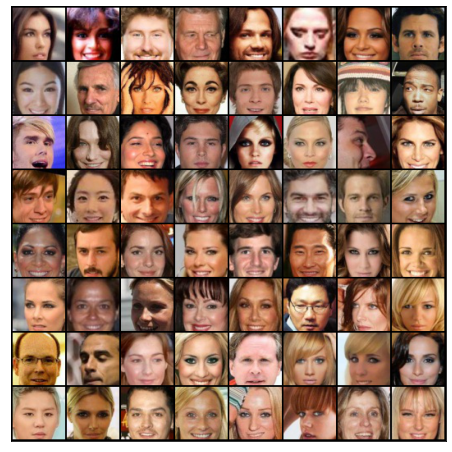

In [10]:
show_batch(train_dl)

In [11]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [12]:
device = get_default_device()
device

device(type='cuda')

In [13]:
train_dl = DeviceDataLoader(train_dl, device)

In [14]:
discriminator = nn.Sequential(
    # in: 3 x 64 x 64

    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 64 x 32 x 32

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 128 x 16 x 16

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 256 x 8 x 8

    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 512 x 4 x 4

    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
    # out: 1 x 1 x 1

    nn.Flatten(),
    nn.Sigmoid())

In [15]:
discriminator = to_device(discriminator, device)

In [16]:
latent_size = 128

In [17]:
generator = nn.Sequential(
    # in: latent_size x 1 x 1

    nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # out: 512 x 4 x 4

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # out: 256 x 8 x 8

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # out: 128 x 16 x 16

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # out: 64 x 32 x 32

    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
    # out: 3 x 64 x 64
)

torch.Size([128, 3, 64, 64])


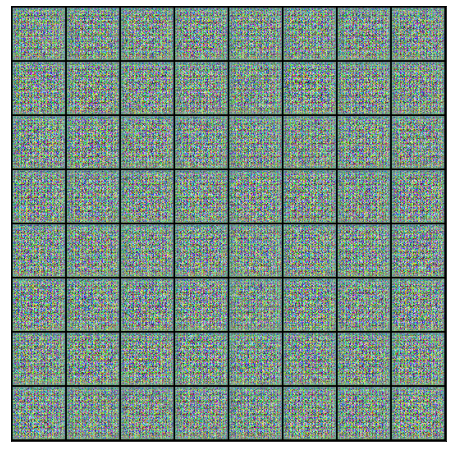

In [18]:
xb = torch.randn(batch_size, latent_size, 1, 1) # random latent tensors
fake_images = generator(xb)
print(fake_images.shape)
show_images(fake_images)

In [19]:
generator = to_device(generator, device)

In [20]:
def train_discriminator(real_images, opt_d):
    # Clear discriminator gradients
    opt_d.zero_grad()

    # Pass real images through discriminator
    real_preds = discriminator(real_images)
    real_targets = torch.ones(real_images.size(0), 1, device=device)
    real_loss = F.binary_cross_entropy(real_preds, real_targets)
    real_score = torch.mean(real_preds).item()
    
    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)

    # Pass fake images through discriminator
    fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
    fake_preds = discriminator(fake_images)
    fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
    fake_score = torch.mean(fake_preds).item()

    # Update discriminator weights
    loss = real_loss + fake_loss
    loss.backward()
    opt_d.step()
    return loss.item(), real_score, fake_score

In [21]:
def train_generator(opt_g):
    # Clear generator gradients
    opt_g.zero_grad()
    
    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)
    
    # Try to fool the discriminator
    preds = discriminator(fake_images)
    targets = torch.ones(batch_size, 1, device=device)
    loss = F.binary_cross_entropy(preds, targets)
    
    # Update generator weights
    loss.backward()
    opt_g.step()
    
    return loss.item()

In [22]:
sample_dir = '/home/barc/Desktop/subir/Face-DCGAN/generated'
os.makedirs(sample_dir, exist_ok=True)

In [23]:
def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

In [24]:
fixed_latent = torch.randn(64, latent_size, 1, 1, device=device)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saving generated-images-0000.png


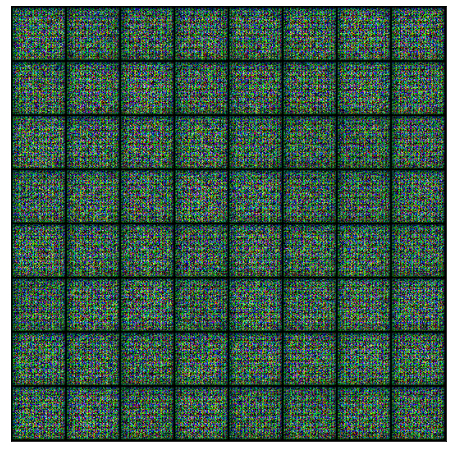

In [25]:
save_samples(0, fixed_latent)

In [26]:
def fit(epochs, lr, start_idx=1):
    torch.cuda.empty_cache()
    
    # Losses & scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []
    
    # Create optimizers
    opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
    opt_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
    
    for epoch in range(epochs):
        for real_images, _ in tqdm(train_dl):
            # Train discriminator
            loss_d, real_score, fake_score = train_discriminator(real_images, opt_d)
            # Train generator
            loss_g = train_generator(opt_g)
            
        # Record losses & scores
        losses_g.append(loss_g)
        losses_d.append(loss_d)
        real_scores.append(real_score)
        fake_scores.append(fake_score)
        
        # Log losses & scores (last batch)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs, loss_g, loss_d, real_score, fake_score))
    
        # Save generated images 
        save_samples(epoch+start_idx, fixed_latent, show=False)
    
    return losses_g, losses_d, real_scores, fake_scores

In [27]:
lr = 0.0002
epochs = 500

In [28]:
history = fit(epochs, lr)

  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [1/500], loss_g: 6.5373, loss_d: 0.1265, real_score: 0.9640, fake_score: 0.0697
Saving generated-images-0001.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [2/500], loss_g: 7.0826, loss_d: 0.0043, real_score: 0.9982, fake_score: 0.0024
Saving generated-images-0002.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [3/500], loss_g: 3.9981, loss_d: 0.1375, real_score: 0.9164, fake_score: 0.0395
Saving generated-images-0003.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [4/500], loss_g: 5.4031, loss_d: 0.7680, real_score: 0.9812, fake_score: 0.4039
Saving generated-images-0004.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [5/500], loss_g: 3.3389, loss_d: 0.7459, real_score: 0.6887, fake_score: 0.1524
Saving generated-images-0005.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [6/500], loss_g: 3.8102, loss_d: 0.3504, real_score: 0.9225, fake_score: 0.2039
Saving generated-images-0006.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [7/500], loss_g: 2.7818, loss_d: 0.4026, real_score: 0.7608, fake_score: 0.0636
Saving generated-images-0007.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [8/500], loss_g: 4.2479, loss_d: 0.1350, real_score: 0.9221, fake_score: 0.0455
Saving generated-images-0008.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [9/500], loss_g: 4.2283, loss_d: 0.2506, real_score: 0.9097, fake_score: 0.1299
Saving generated-images-0009.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [10/500], loss_g: 3.2105, loss_d: 0.9247, real_score: 0.5015, fake_score: 0.0097
Saving generated-images-0010.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [11/500], loss_g: 3.3401, loss_d: 0.3123, real_score: 0.8179, fake_score: 0.0795
Saving generated-images-0011.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [12/500], loss_g: 4.3146, loss_d: 0.3502, real_score: 0.8569, fake_score: 0.1542
Saving generated-images-0012.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [13/500], loss_g: 6.5444, loss_d: 1.0401, real_score: 0.9923, fake_score: 0.5627
Saving generated-images-0013.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [14/500], loss_g: 2.3256, loss_d: 0.3897, real_score: 0.9025, fake_score: 0.2155
Saving generated-images-0014.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [15/500], loss_g: 3.9340, loss_d: 0.3346, real_score: 0.8467, fake_score: 0.1151
Saving generated-images-0015.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [16/500], loss_g: 3.3295, loss_d: 0.1455, real_score: 0.9885, fake_score: 0.1162
Saving generated-images-0016.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [17/500], loss_g: 4.9868, loss_d: 0.2491, real_score: 0.9921, fake_score: 0.1918
Saving generated-images-0017.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [18/500], loss_g: 4.7958, loss_d: 0.0414, real_score: 0.9760, fake_score: 0.0162
Saving generated-images-0018.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [19/500], loss_g: 5.8144, loss_d: 0.0735, real_score: 0.9921, fake_score: 0.0607
Saving generated-images-0019.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [20/500], loss_g: 4.6309, loss_d: 0.1813, real_score: 0.9138, fake_score: 0.0741
Saving generated-images-0020.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [21/500], loss_g: 2.7191, loss_d: 0.6469, real_score: 0.5814, fake_score: 0.0016
Saving generated-images-0021.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [22/500], loss_g: 5.4642, loss_d: 0.5357, real_score: 0.6460, fake_score: 0.0017
Saving generated-images-0022.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [23/500], loss_g: 2.6760, loss_d: 0.0789, real_score: 0.9909, fake_score: 0.0631
Saving generated-images-0023.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [24/500], loss_g: 4.8343, loss_d: 0.0963, real_score: 0.9194, fake_score: 0.0086
Saving generated-images-0024.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [25/500], loss_g: 6.1168, loss_d: 2.5818, real_score: 0.1359, fake_score: 0.0000
Saving generated-images-0025.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [26/500], loss_g: 4.2935, loss_d: 0.1339, real_score: 0.9142, fake_score: 0.0382
Saving generated-images-0026.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [27/500], loss_g: 4.3289, loss_d: 0.1201, real_score: 0.9677, fake_score: 0.0768
Saving generated-images-0027.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [28/500], loss_g: 4.2382, loss_d: 0.0668, real_score: 0.9954, fake_score: 0.0580
Saving generated-images-0028.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [29/500], loss_g: 5.1767, loss_d: 0.0707, real_score: 0.9445, fake_score: 0.0107
Saving generated-images-0029.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [30/500], loss_g: 4.4123, loss_d: 0.0417, real_score: 0.9858, fake_score: 0.0263
Saving generated-images-0030.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [31/500], loss_g: 4.5291, loss_d: 0.0889, real_score: 0.9699, fake_score: 0.0541
Saving generated-images-0031.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [32/500], loss_g: 5.5663, loss_d: 0.0738, real_score: 0.9335, fake_score: 0.0024
Saving generated-images-0032.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [33/500], loss_g: 10.0744, loss_d: 1.7622, real_score: 0.9933, fake_score: 0.7644
Saving generated-images-0033.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [34/500], loss_g: 3.4993, loss_d: 0.1860, real_score: 0.9076, fake_score: 0.0759
Saving generated-images-0034.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [35/500], loss_g: 4.9714, loss_d: 0.1589, real_score: 0.9667, fake_score: 0.1114
Saving generated-images-0035.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [36/500], loss_g: 6.6433, loss_d: 0.0519, real_score: 0.9554, fake_score: 0.0046
Saving generated-images-0036.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [37/500], loss_g: 5.5157, loss_d: 0.0297, real_score: 0.9839, fake_score: 0.0119
Saving generated-images-0037.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [38/500], loss_g: 4.1639, loss_d: 0.5319, real_score: 0.6581, fake_score: 0.0047
Saving generated-images-0038.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [39/500], loss_g: 11.7056, loss_d: 0.0227, real_score: 0.9780, fake_score: 0.0000
Saving generated-images-0039.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [40/500], loss_g: 3.6579, loss_d: 0.2492, real_score: 0.8330, fake_score: 0.0048
Saving generated-images-0040.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [41/500], loss_g: 5.1223, loss_d: 0.0370, real_score: 0.9715, fake_score: 0.0073
Saving generated-images-0041.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [42/500], loss_g: 8.6155, loss_d: 0.0270, real_score: 0.9744, fake_score: 0.0007
Saving generated-images-0042.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [43/500], loss_g: 4.4510, loss_d: 0.1234, real_score: 0.9447, fake_score: 0.0586
Saving generated-images-0043.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [44/500], loss_g: 9.3414, loss_d: 0.0263, real_score: 0.9767, fake_score: 0.0002
Saving generated-images-0044.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [45/500], loss_g: 5.6492, loss_d: 0.0630, real_score: 0.9606, fake_score: 0.0203
Saving generated-images-0045.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [46/500], loss_g: 9.2408, loss_d: 0.0147, real_score: 0.9862, fake_score: 0.0006
Saving generated-images-0046.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [47/500], loss_g: 8.8524, loss_d: 0.8277, real_score: 0.9993, fake_score: 0.4655
Saving generated-images-0047.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [48/500], loss_g: 2.6436, loss_d: 0.0338, real_score: 0.9916, fake_score: 0.0245
Saving generated-images-0048.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [49/500], loss_g: 5.6383, loss_d: 0.1084, real_score: 0.9124, fake_score: 0.0064
Saving generated-images-0049.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [50/500], loss_g: 6.6101, loss_d: 0.6259, real_score: 0.9883, fake_score: 0.3852
Saving generated-images-0050.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [51/500], loss_g: 5.1422, loss_d: 0.0263, real_score: 0.9987, fake_score: 0.0241
Saving generated-images-0051.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [52/500], loss_g: 4.4155, loss_d: 0.0822, real_score: 0.9907, fake_score: 0.0674
Saving generated-images-0052.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [53/500], loss_g: 4.7065, loss_d: 0.0500, real_score: 0.9848, fake_score: 0.0328
Saving generated-images-0053.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [54/500], loss_g: 6.8701, loss_d: 0.3863, real_score: 0.9904, fake_score: 0.2730
Saving generated-images-0054.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [55/500], loss_g: 4.2606, loss_d: 0.2394, real_score: 0.9880, fake_score: 0.1847
Saving generated-images-0055.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [56/500], loss_g: 5.1052, loss_d: 0.0803, real_score: 0.9854, fake_score: 0.0611
Saving generated-images-0056.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [57/500], loss_g: 9.2307, loss_d: 0.5191, real_score: 0.9839, fake_score: 0.3488
Saving generated-images-0057.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [58/500], loss_g: 4.5847, loss_d: 0.5631, real_score: 0.6696, fake_score: 0.0050
Saving generated-images-0058.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [59/500], loss_g: 4.5192, loss_d: 0.1505, real_score: 0.9732, fake_score: 0.0999
Saving generated-images-0059.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [60/500], loss_g: 8.6879, loss_d: 0.0439, real_score: 0.9584, fake_score: 0.0004
Saving generated-images-0060.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [61/500], loss_g: 1.9315, loss_d: 0.8442, real_score: 0.6318, fake_score: 0.0490
Saving generated-images-0061.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [62/500], loss_g: 9.7330, loss_d: 0.6477, real_score: 0.9925, fake_score: 0.4021
Saving generated-images-0062.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [63/500], loss_g: 6.9947, loss_d: 0.0293, real_score: 0.9750, fake_score: 0.0030
Saving generated-images-0063.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [64/500], loss_g: 12.8536, loss_d: 1.0545, real_score: 0.9999, fake_score: 0.5565
Saving generated-images-0064.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [65/500], loss_g: 4.4173, loss_d: 0.0432, real_score: 0.9742, fake_score: 0.0156
Saving generated-images-0065.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [66/500], loss_g: 4.6103, loss_d: 0.0353, real_score: 0.9827, fake_score: 0.0171
Saving generated-images-0066.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [67/500], loss_g: 3.0765, loss_d: 0.0613, real_score: 0.9967, fake_score: 0.0466
Saving generated-images-0067.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [68/500], loss_g: 6.8493, loss_d: 0.0055, real_score: 0.9956, fake_score: 0.0011
Saving generated-images-0068.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [69/500], loss_g: 6.3484, loss_d: 0.0898, real_score: 0.9928, fake_score: 0.0751
Saving generated-images-0069.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [70/500], loss_g: 5.8590, loss_d: 0.0518, real_score: 0.9845, fake_score: 0.0339
Saving generated-images-0070.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [71/500], loss_g: 7.6462, loss_d: 0.1123, real_score: 0.9064, fake_score: 0.0003
Saving generated-images-0071.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [72/500], loss_g: 5.0543, loss_d: 0.0978, real_score: 0.9217, fake_score: 0.0023
Saving generated-images-0072.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [73/500], loss_g: 5.8929, loss_d: 0.0362, real_score: 0.9711, fake_score: 0.0064
Saving generated-images-0073.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [74/500], loss_g: 4.5075, loss_d: 0.1148, real_score: 0.9358, fake_score: 0.0368
Saving generated-images-0074.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [75/500], loss_g: 4.9576, loss_d: 0.0997, real_score: 0.9721, fake_score: 0.0627
Saving generated-images-0075.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [76/500], loss_g: 6.8962, loss_d: 0.2855, real_score: 0.9993, fake_score: 0.2041
Saving generated-images-0076.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [77/500], loss_g: 7.0173, loss_d: 0.0177, real_score: 0.9956, fake_score: 0.0129
Saving generated-images-0077.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [78/500], loss_g: 4.8746, loss_d: 0.1585, real_score: 0.9651, fake_score: 0.1070
Saving generated-images-0078.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [79/500], loss_g: 4.5959, loss_d: 0.0727, real_score: 0.9654, fake_score: 0.0314
Saving generated-images-0079.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [80/500], loss_g: 5.4904, loss_d: 0.0615, real_score: 0.9548, fake_score: 0.0121
Saving generated-images-0080.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [81/500], loss_g: 5.8551, loss_d: 0.0092, real_score: 0.9980, fake_score: 0.0070
Saving generated-images-0081.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [82/500], loss_g: 5.4647, loss_d: 0.1875, real_score: 0.9943, fake_score: 0.1503
Saving generated-images-0082.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [83/500], loss_g: 5.4104, loss_d: 0.0163, real_score: 0.9915, fake_score: 0.0076
Saving generated-images-0083.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [84/500], loss_g: 4.6341, loss_d: 0.1044, real_score: 0.9975, fake_score: 0.0912
Saving generated-images-0084.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [85/500], loss_g: 2.6544, loss_d: 0.2345, real_score: 0.8255, fake_score: 0.0187
Saving generated-images-0085.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [86/500], loss_g: 5.3843, loss_d: 0.1066, real_score: 0.9359, fake_score: 0.0326
Saving generated-images-0086.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [87/500], loss_g: 5.0557, loss_d: 0.0594, real_score: 0.9633, fake_score: 0.0198
Saving generated-images-0087.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [88/500], loss_g: 4.8727, loss_d: 0.1425, real_score: 0.9064, fake_score: 0.0111
Saving generated-images-0088.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [89/500], loss_g: 5.4573, loss_d: 0.1123, real_score: 0.9145, fake_score: 0.0138
Saving generated-images-0089.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [90/500], loss_g: 4.8588, loss_d: 0.0721, real_score: 0.9849, fake_score: 0.0505
Saving generated-images-0090.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [91/500], loss_g: 4.3840, loss_d: 0.1815, real_score: 0.8546, fake_score: 0.0022
Saving generated-images-0091.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [92/500], loss_g: 5.5291, loss_d: 1.6163, real_score: 0.2852, fake_score: 0.0000
Saving generated-images-0092.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [93/500], loss_g: 4.8275, loss_d: 0.0456, real_score: 0.9882, fake_score: 0.0321
Saving generated-images-0093.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [94/500], loss_g: 2.7426, loss_d: 0.2053, real_score: 0.8360, fake_score: 0.0044
Saving generated-images-0094.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [95/500], loss_g: 4.7293, loss_d: 0.0486, real_score: 0.9919, fake_score: 0.0384
Saving generated-images-0095.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [96/500], loss_g: 4.5877, loss_d: 0.2779, real_score: 0.9641, fake_score: 0.1816
Saving generated-images-0096.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [97/500], loss_g: 4.0823, loss_d: 0.0469, real_score: 0.9876, fake_score: 0.0328
Saving generated-images-0097.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [98/500], loss_g: 4.8485, loss_d: 0.0335, real_score: 0.9843, fake_score: 0.0170
Saving generated-images-0098.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [99/500], loss_g: 3.1797, loss_d: 0.1358, real_score: 0.8870, fake_score: 0.0074
Saving generated-images-0099.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [100/500], loss_g: 5.6799, loss_d: 0.3400, real_score: 0.7625, fake_score: 0.0023
Saving generated-images-0100.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [101/500], loss_g: 1.1816, loss_d: 1.0125, real_score: 0.4735, fake_score: 0.0017
Saving generated-images-0101.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [102/500], loss_g: 5.6173, loss_d: 0.0976, real_score: 0.9836, fake_score: 0.0734
Saving generated-images-0102.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [103/500], loss_g: 7.1139, loss_d: 0.1004, real_score: 0.9169, fake_score: 0.0028
Saving generated-images-0103.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [104/500], loss_g: 3.9845, loss_d: 0.0960, real_score: 0.9420, fake_score: 0.0302
Saving generated-images-0104.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [105/500], loss_g: 5.8189, loss_d: 0.0453, real_score: 0.9741, fake_score: 0.0177
Saving generated-images-0105.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [106/500], loss_g: 5.7086, loss_d: 0.0600, real_score: 0.9886, fake_score: 0.0446
Saving generated-images-0106.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [107/500], loss_g: 7.2761, loss_d: 0.0266, real_score: 0.9772, fake_score: 0.0026
Saving generated-images-0107.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [108/500], loss_g: 5.1676, loss_d: 0.0730, real_score: 0.9486, fake_score: 0.0171
Saving generated-images-0108.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [109/500], loss_g: 6.0332, loss_d: 0.1475, real_score: 0.8831, fake_score: 0.0016
Saving generated-images-0109.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [110/500], loss_g: 7.9708, loss_d: 0.3440, real_score: 0.9948, fake_score: 0.2566
Saving generated-images-0110.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [111/500], loss_g: 8.9468, loss_d: 0.4169, real_score: 0.9992, fake_score: 0.2785
Saving generated-images-0111.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [112/500], loss_g: 5.3676, loss_d: 0.1171, real_score: 0.9095, fake_score: 0.0098
Saving generated-images-0112.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [113/500], loss_g: 5.4330, loss_d: 0.1087, real_score: 0.9968, fake_score: 0.0759
Saving generated-images-0113.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [114/500], loss_g: 5.6280, loss_d: 0.0971, real_score: 0.9331, fake_score: 0.0181
Saving generated-images-0114.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [115/500], loss_g: 9.5244, loss_d: 0.0281, real_score: 0.9745, fake_score: 0.0007
Saving generated-images-0115.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [116/500], loss_g: 5.4765, loss_d: 0.0834, real_score: 0.9856, fake_score: 0.0592
Saving generated-images-0116.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [117/500], loss_g: 2.9409, loss_d: 2.7802, real_score: 0.1343, fake_score: 0.0001
Saving generated-images-0117.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [118/500], loss_g: 5.0140, loss_d: 0.0521, real_score: 0.9793, fake_score: 0.0278
Saving generated-images-0118.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [119/500], loss_g: 4.9626, loss_d: 0.0880, real_score: 0.9736, fake_score: 0.0544
Saving generated-images-0119.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [120/500], loss_g: 4.8831, loss_d: 0.0844, real_score: 0.9849, fake_score: 0.0624
Saving generated-images-0120.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [121/500], loss_g: 6.1937, loss_d: 0.1863, real_score: 0.9941, fake_score: 0.1351
Saving generated-images-0121.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [122/500], loss_g: 7.2127, loss_d: 0.0388, real_score: 0.9673, fake_score: 0.0013
Saving generated-images-0122.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [123/500], loss_g: 4.6099, loss_d: 0.1014, real_score: 0.9287, fake_score: 0.0177
Saving generated-images-0123.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [124/500], loss_g: 11.1204, loss_d: 0.7284, real_score: 0.9995, fake_score: 0.4219
Saving generated-images-0124.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [125/500], loss_g: 7.7161, loss_d: 0.0837, real_score: 0.9290, fake_score: 0.0013
Saving generated-images-0125.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [126/500], loss_g: 6.1439, loss_d: 0.0554, real_score: 0.9511, fake_score: 0.0024
Saving generated-images-0126.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [127/500], loss_g: 4.8064, loss_d: 0.0847, real_score: 0.9968, fake_score: 0.0726
Saving generated-images-0127.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [128/500], loss_g: 5.5513, loss_d: 0.0592, real_score: 0.9643, fake_score: 0.0206
Saving generated-images-0128.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [129/500], loss_g: 1.8405, loss_d: 1.1032, real_score: 0.4776, fake_score: 0.0113
Saving generated-images-0129.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [130/500], loss_g: 4.6491, loss_d: 0.0991, real_score: 0.9660, fake_score: 0.0574
Saving generated-images-0130.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [131/500], loss_g: 4.8053, loss_d: 0.0931, real_score: 0.9870, fake_score: 0.0686
Saving generated-images-0131.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [132/500], loss_g: 5.5185, loss_d: 0.2704, real_score: 0.9941, fake_score: 0.1894
Saving generated-images-0132.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [133/500], loss_g: 6.1108, loss_d: 0.0336, real_score: 0.9769, fake_score: 0.0095
Saving generated-images-0133.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [134/500], loss_g: 5.4074, loss_d: 0.1591, real_score: 0.9843, fake_score: 0.1200
Saving generated-images-0134.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [135/500], loss_g: 5.7313, loss_d: 0.0370, real_score: 0.9935, fake_score: 0.0291
Saving generated-images-0135.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [136/500], loss_g: 4.4040, loss_d: 0.1434, real_score: 0.8994, fake_score: 0.0223
Saving generated-images-0136.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [137/500], loss_g: 5.9786, loss_d: 0.0266, real_score: 0.9829, fake_score: 0.0087
Saving generated-images-0137.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [138/500], loss_g: 4.9134, loss_d: 0.1492, real_score: 0.9976, fake_score: 0.1132
Saving generated-images-0138.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [139/500], loss_g: 4.6767, loss_d: 0.1429, real_score: 0.9915, fake_score: 0.1041
Saving generated-images-0139.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [140/500], loss_g: 7.2964, loss_d: 0.3747, real_score: 0.9921, fake_score: 0.2655
Saving generated-images-0140.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [141/500], loss_g: 5.1916, loss_d: 0.0749, real_score: 0.9471, fake_score: 0.0158
Saving generated-images-0141.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [142/500], loss_g: 4.4698, loss_d: 0.1021, real_score: 0.9246, fake_score: 0.0179
Saving generated-images-0142.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [143/500], loss_g: 5.4532, loss_d: 0.0352, real_score: 0.9977, fake_score: 0.0308
Saving generated-images-0143.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [144/500], loss_g: 5.5897, loss_d: 0.0647, real_score: 0.9638, fake_score: 0.0210
Saving generated-images-0144.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [145/500], loss_g: 4.6983, loss_d: 0.0338, real_score: 0.9908, fake_score: 0.0231
Saving generated-images-0145.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [146/500], loss_g: 6.9460, loss_d: 0.0830, real_score: 0.9975, fake_score: 0.0706
Saving generated-images-0146.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [147/500], loss_g: 4.8458, loss_d: 0.0835, real_score: 0.9950, fake_score: 0.0712
Saving generated-images-0147.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [148/500], loss_g: 4.1059, loss_d: 0.0313, real_score: 0.9887, fake_score: 0.0166
Saving generated-images-0148.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [149/500], loss_g: 5.7746, loss_d: 0.1523, real_score: 0.9693, fake_score: 0.1003
Saving generated-images-0149.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [150/500], loss_g: 3.4836, loss_d: 0.2125, real_score: 0.8345, fake_score: 0.0033
Saving generated-images-0150.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [151/500], loss_g: 6.0983, loss_d: 0.0308, real_score: 0.9741, fake_score: 0.0040
Saving generated-images-0151.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [152/500], loss_g: 9.4199, loss_d: 0.2864, real_score: 0.9991, fake_score: 0.2162
Saving generated-images-0152.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [153/500], loss_g: 5.7567, loss_d: 0.0705, real_score: 0.9838, fake_score: 0.0448
Saving generated-images-0153.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [154/500], loss_g: 4.6015, loss_d: 0.2351, real_score: 0.9948, fake_score: 0.1685
Saving generated-images-0154.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [155/500], loss_g: 5.6532, loss_d: 0.0847, real_score: 0.9419, fake_score: 0.0153
Saving generated-images-0155.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [156/500], loss_g: 7.6115, loss_d: 0.0492, real_score: 0.9655, fake_score: 0.0126
Saving generated-images-0156.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [157/500], loss_g: 5.5814, loss_d: 0.0527, real_score: 0.9534, fake_score: 0.0030
Saving generated-images-0157.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [158/500], loss_g: 4.9095, loss_d: 0.0538, real_score: 0.9800, fake_score: 0.0296
Saving generated-images-0158.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [159/500], loss_g: 7.1954, loss_d: 0.0285, real_score: 0.9850, fake_score: 0.0124
Saving generated-images-0159.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [160/500], loss_g: 4.1746, loss_d: 0.7833, real_score: 0.5423, fake_score: 0.0000
Saving generated-images-0160.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [161/500], loss_g: 6.1890, loss_d: 0.1325, real_score: 0.9980, fake_score: 0.1061
Saving generated-images-0161.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [162/500], loss_g: 5.6470, loss_d: 0.0588, real_score: 0.9604, fake_score: 0.0141
Saving generated-images-0162.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [163/500], loss_g: 8.5043, loss_d: 0.1902, real_score: 0.9956, fake_score: 0.1476
Saving generated-images-0163.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [164/500], loss_g: 5.9219, loss_d: 0.1170, real_score: 0.9092, fake_score: 0.0103
Saving generated-images-0164.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [165/500], loss_g: 5.9498, loss_d: 0.0490, real_score: 0.9667, fake_score: 0.0130
Saving generated-images-0165.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [166/500], loss_g: 6.3276, loss_d: 0.0438, real_score: 0.9677, fake_score: 0.0085
Saving generated-images-0166.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [167/500], loss_g: 6.0497, loss_d: 0.0196, real_score: 0.9918, fake_score: 0.0111
Saving generated-images-0167.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [168/500], loss_g: 4.3756, loss_d: 0.0682, real_score: 0.9530, fake_score: 0.0167
Saving generated-images-0168.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [169/500], loss_g: 6.4098, loss_d: 0.0246, real_score: 0.9769, fake_score: 0.0005
Saving generated-images-0169.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [170/500], loss_g: 3.4588, loss_d: 0.1196, real_score: 0.9199, fake_score: 0.0246
Saving generated-images-0170.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [171/500], loss_g: 4.8981, loss_d: 0.0610, real_score: 0.9786, fake_score: 0.0360
Saving generated-images-0171.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [172/500], loss_g: 4.1221, loss_d: 0.6322, real_score: 0.8714, fake_score: 0.2080
Saving generated-images-0172.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [173/500], loss_g: 6.4753, loss_d: 0.1339, real_score: 0.8903, fake_score: 0.0038
Saving generated-images-0173.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [174/500], loss_g: 5.6148, loss_d: 0.0333, real_score: 0.9848, fake_score: 0.0173
Saving generated-images-0174.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [175/500], loss_g: 5.6948, loss_d: 0.0886, real_score: 0.9827, fake_score: 0.0571
Saving generated-images-0175.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [176/500], loss_g: 5.3734, loss_d: 0.0223, real_score: 0.9947, fake_score: 0.0165
Saving generated-images-0176.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [177/500], loss_g: 8.1872, loss_d: 0.2105, real_score: 0.9839, fake_score: 0.1513
Saving generated-images-0177.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [178/500], loss_g: 3.8352, loss_d: 0.0294, real_score: 0.9880, fake_score: 0.0165
Saving generated-images-0178.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [179/500], loss_g: 2.5106, loss_d: 0.2456, real_score: 0.8260, fake_score: 0.0204
Saving generated-images-0179.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [180/500], loss_g: 5.8448, loss_d: 0.0545, real_score: 0.9554, fake_score: 0.0067
Saving generated-images-0180.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [181/500], loss_g: 4.5382, loss_d: 0.0884, real_score: 0.9791, fake_score: 0.0572
Saving generated-images-0181.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [182/500], loss_g: 6.0524, loss_d: 0.1210, real_score: 0.9927, fake_score: 0.0986
Saving generated-images-0182.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [183/500], loss_g: 4.6093, loss_d: 0.0330, real_score: 0.9786, fake_score: 0.0107
Saving generated-images-0183.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [184/500], loss_g: 5.5146, loss_d: 0.1474, real_score: 0.8934, fake_score: 0.0134
Saving generated-images-0184.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [185/500], loss_g: 6.5336, loss_d: 0.0839, real_score: 0.9920, fake_score: 0.0671
Saving generated-images-0185.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [186/500], loss_g: 4.9955, loss_d: 0.0231, real_score: 0.9889, fake_score: 0.0116
Saving generated-images-0186.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [187/500], loss_g: 5.3889, loss_d: 0.0270, real_score: 0.9911, fake_score: 0.0169
Saving generated-images-0187.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [188/500], loss_g: 6.4828, loss_d: 0.1360, real_score: 0.8873, fake_score: 0.0008
Saving generated-images-0188.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [189/500], loss_g: 3.1089, loss_d: 0.2379, real_score: 0.8501, fake_score: 0.0210
Saving generated-images-0189.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [190/500], loss_g: 4.1459, loss_d: 0.0688, real_score: 0.9530, fake_score: 0.0167
Saving generated-images-0190.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [191/500], loss_g: 6.8409, loss_d: 0.0644, real_score: 0.9832, fake_score: 0.0445
Saving generated-images-0191.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [192/500], loss_g: 4.2172, loss_d: 0.2141, real_score: 0.9196, fake_score: 0.0983
Saving generated-images-0192.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [193/500], loss_g: 5.8445, loss_d: 0.0205, real_score: 0.9947, fake_score: 0.0148
Saving generated-images-0193.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [194/500], loss_g: 6.8103, loss_d: 0.0207, real_score: 0.9884, fake_score: 0.0084
Saving generated-images-0194.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [195/500], loss_g: 4.3236, loss_d: 0.0249, real_score: 0.9990, fake_score: 0.0212
Saving generated-images-0195.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [196/500], loss_g: 5.5611, loss_d: 0.0463, real_score: 0.9711, fake_score: 0.0152
Saving generated-images-0196.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [197/500], loss_g: 5.3640, loss_d: 0.0702, real_score: 0.9664, fake_score: 0.0315
Saving generated-images-0197.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [198/500], loss_g: 4.4354, loss_d: 0.0861, real_score: 0.9506, fake_score: 0.0279
Saving generated-images-0198.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [199/500], loss_g: 5.8132, loss_d: 0.0278, real_score: 0.9908, fake_score: 0.0178
Saving generated-images-0199.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [200/500], loss_g: 7.7628, loss_d: 0.0237, real_score: 0.9965, fake_score: 0.0192
Saving generated-images-0200.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [201/500], loss_g: 5.2051, loss_d: 0.0676, real_score: 0.9609, fake_score: 0.0235
Saving generated-images-0201.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [202/500], loss_g: 5.0261, loss_d: 0.0512, real_score: 0.9853, fake_score: 0.0342
Saving generated-images-0202.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [203/500], loss_g: 5.1809, loss_d: 0.1056, real_score: 0.9459, fake_score: 0.0283
Saving generated-images-0203.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [204/500], loss_g: 4.8432, loss_d: 0.0926, real_score: 0.9276, fake_score: 0.0124
Saving generated-images-0204.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [205/500], loss_g: 6.3601, loss_d: 0.0972, real_score: 0.9761, fake_score: 0.0567
Saving generated-images-0205.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [206/500], loss_g: 6.0041, loss_d: 0.0261, real_score: 0.9872, fake_score: 0.0125
Saving generated-images-0206.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [207/500], loss_g: 3.9670, loss_d: 0.1382, real_score: 0.9320, fake_score: 0.0486
Saving generated-images-0207.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [208/500], loss_g: 3.8852, loss_d: 0.1903, real_score: 0.9401, fake_score: 0.0976
Saving generated-images-0208.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [209/500], loss_g: 6.1252, loss_d: 0.0276, real_score: 0.9913, fake_score: 0.0181
Saving generated-images-0209.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [210/500], loss_g: 7.7417, loss_d: 0.1812, real_score: 0.9988, fake_score: 0.1433
Saving generated-images-0210.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [211/500], loss_g: 6.2978, loss_d: 0.1316, real_score: 0.9767, fake_score: 0.0903
Saving generated-images-0211.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [212/500], loss_g: 5.3763, loss_d: 0.0300, real_score: 0.9915, fake_score: 0.0206
Saving generated-images-0212.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [213/500], loss_g: 6.6042, loss_d: 0.0886, real_score: 0.9513, fake_score: 0.0242
Saving generated-images-0213.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [214/500], loss_g: 4.9567, loss_d: 0.0368, real_score: 0.9985, fake_score: 0.0328
Saving generated-images-0214.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [215/500], loss_g: 4.7970, loss_d: 0.0577, real_score: 0.9641, fake_score: 0.0141
Saving generated-images-0215.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [216/500], loss_g: 9.2915, loss_d: 1.9019, real_score: 0.9978, fake_score: 0.5648
Saving generated-images-0216.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [217/500], loss_g: 6.0283, loss_d: 0.2225, real_score: 0.9975, fake_score: 0.1679
Saving generated-images-0217.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [218/500], loss_g: 6.2093, loss_d: 0.0153, real_score: 0.9954, fake_score: 0.0103
Saving generated-images-0218.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [219/500], loss_g: 4.1765, loss_d: 0.6738, real_score: 0.6299, fake_score: 0.0044
Saving generated-images-0219.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [220/500], loss_g: 4.0404, loss_d: 0.1427, real_score: 0.9319, fake_score: 0.0589
Saving generated-images-0220.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [221/500], loss_g: 6.0166, loss_d: 0.0115, real_score: 0.9933, fake_score: 0.0047
Saving generated-images-0221.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [222/500], loss_g: 6.0191, loss_d: 0.0197, real_score: 0.9880, fake_score: 0.0073
Saving generated-images-0222.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [223/500], loss_g: 6.2586, loss_d: 0.0473, real_score: 0.9940, fake_score: 0.0350
Saving generated-images-0223.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [224/500], loss_g: 8.4696, loss_d: 0.0226, real_score: 0.9841, fake_score: 0.0053
Saving generated-images-0224.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [225/500], loss_g: 4.8459, loss_d: 0.0303, real_score: 0.9794, fake_score: 0.0090
Saving generated-images-0225.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [226/500], loss_g: 6.5812, loss_d: 0.0146, real_score: 0.9917, fake_score: 0.0061
Saving generated-images-0226.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [227/500], loss_g: 7.6514, loss_d: 0.0160, real_score: 0.9933, fake_score: 0.0092
Saving generated-images-0227.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [228/500], loss_g: 4.4245, loss_d: 0.0754, real_score: 0.9818, fake_score: 0.0407
Saving generated-images-0228.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [229/500], loss_g: 7.1427, loss_d: 0.0202, real_score: 0.9847, fake_score: 0.0045
Saving generated-images-0229.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [230/500], loss_g: 5.3603, loss_d: 0.0571, real_score: 0.9758, fake_score: 0.0290
Saving generated-images-0230.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [231/500], loss_g: 5.3720, loss_d: 0.0560, real_score: 0.9923, fake_score: 0.0386
Saving generated-images-0231.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [232/500], loss_g: 5.3478, loss_d: 0.0309, real_score: 0.9844, fake_score: 0.0136
Saving generated-images-0232.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [233/500], loss_g: 4.5557, loss_d: 0.0985, real_score: 0.9559, fake_score: 0.0217
Saving generated-images-0233.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [234/500], loss_g: 0.2249, loss_d: 1.0500, real_score: 0.5220, fake_score: 0.0197
Saving generated-images-0234.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [235/500], loss_g: 7.2791, loss_d: 0.0069, real_score: 0.9959, fake_score: 0.0028
Saving generated-images-0235.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [236/500], loss_g: 6.3453, loss_d: 0.0177, real_score: 0.9969, fake_score: 0.0140
Saving generated-images-0236.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [237/500], loss_g: 7.0396, loss_d: 0.0566, real_score: 0.9775, fake_score: 0.0293
Saving generated-images-0237.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [238/500], loss_g: 5.2806, loss_d: 0.0607, real_score: 0.9766, fake_score: 0.0335
Saving generated-images-0238.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [239/500], loss_g: 5.6421, loss_d: 0.0329, real_score: 0.9967, fake_score: 0.0268
Saving generated-images-0239.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [240/500], loss_g: 6.9622, loss_d: 0.0507, real_score: 0.9959, fake_score: 0.0431
Saving generated-images-0240.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [241/500], loss_g: 4.3827, loss_d: 0.0497, real_score: 0.9623, fake_score: 0.0089
Saving generated-images-0241.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [242/500], loss_g: 4.7850, loss_d: 0.2511, real_score: 0.9660, fake_score: 0.1414
Saving generated-images-0242.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [243/500], loss_g: 6.6469, loss_d: 0.0418, real_score: 0.9938, fake_score: 0.0290
Saving generated-images-0243.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [244/500], loss_g: 2.4011, loss_d: 0.2458, real_score: 0.8179, fake_score: 0.0063
Saving generated-images-0244.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [245/500], loss_g: 5.7094, loss_d: 0.1082, real_score: 0.9305, fake_score: 0.0238
Saving generated-images-0245.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [246/500], loss_g: 7.1618, loss_d: 0.0310, real_score: 0.9748, fake_score: 0.0049
Saving generated-images-0246.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [247/500], loss_g: 8.5845, loss_d: 0.0135, real_score: 0.9877, fake_score: 0.0010
Saving generated-images-0247.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [248/500], loss_g: 5.9455, loss_d: 0.0656, real_score: 0.9740, fake_score: 0.0347
Saving generated-images-0248.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [249/500], loss_g: 5.3784, loss_d: 0.0675, real_score: 0.9719, fake_score: 0.0328
Saving generated-images-0249.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [250/500], loss_g: 4.5772, loss_d: 0.0747, real_score: 0.9673, fake_score: 0.0150
Saving generated-images-0250.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [251/500], loss_g: 6.5190, loss_d: 0.0726, real_score: 0.9526, fake_score: 0.0152
Saving generated-images-0251.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [252/500], loss_g: 6.5291, loss_d: 0.1031, real_score: 0.9573, fake_score: 0.0446
Saving generated-images-0252.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [253/500], loss_g: 6.1401, loss_d: 0.0275, real_score: 0.9868, fake_score: 0.0132
Saving generated-images-0253.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [254/500], loss_g: 8.1511, loss_d: 0.0155, real_score: 0.9912, fake_score: 0.0063
Saving generated-images-0254.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [255/500], loss_g: 2.5484, loss_d: 0.2311, real_score: 0.8272, fake_score: 0.0119
Saving generated-images-0255.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [256/500], loss_g: 3.4882, loss_d: 0.2512, real_score: 0.9273, fake_score: 0.1172
Saving generated-images-0256.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [257/500], loss_g: 5.9011, loss_d: 0.0202, real_score: 0.9924, fake_score: 0.0122
Saving generated-images-0257.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [258/500], loss_g: 5.2308, loss_d: 0.1233, real_score: 0.9654, fake_score: 0.0611
Saving generated-images-0258.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [259/500], loss_g: 3.6362, loss_d: 2.1637, real_score: 0.2632, fake_score: 0.0002
Saving generated-images-0259.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [260/500], loss_g: 5.5994, loss_d: 0.0491, real_score: 0.9789, fake_score: 0.0251
Saving generated-images-0260.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [261/500], loss_g: 6.3735, loss_d: 0.0197, real_score: 0.9871, fake_score: 0.0065
Saving generated-images-0261.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [262/500], loss_g: 8.1912, loss_d: 0.0486, real_score: 0.9558, fake_score: 0.0008
Saving generated-images-0262.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [263/500], loss_g: 4.9199, loss_d: 0.0690, real_score: 0.9526, fake_score: 0.0146
Saving generated-images-0263.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [264/500], loss_g: 6.5468, loss_d: 0.0245, real_score: 0.9891, fake_score: 0.0128
Saving generated-images-0264.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [265/500], loss_g: 5.6561, loss_d: 0.0718, real_score: 0.9632, fake_score: 0.0292
Saving generated-images-0265.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [266/500], loss_g: 5.8922, loss_d: 0.0935, real_score: 0.9347, fake_score: 0.0179
Saving generated-images-0266.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [267/500], loss_g: 4.6295, loss_d: 0.3778, real_score: 0.8686, fake_score: 0.1512
Saving generated-images-0267.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [268/500], loss_g: 5.3071, loss_d: 0.0962, real_score: 0.9749, fake_score: 0.0630
Saving generated-images-0268.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [269/500], loss_g: 5.4566, loss_d: 0.0609, real_score: 0.9821, fake_score: 0.0387
Saving generated-images-0269.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [270/500], loss_g: 2.8119, loss_d: 0.1586, real_score: 0.8996, fake_score: 0.0277
Saving generated-images-0270.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [271/500], loss_g: 6.5572, loss_d: 0.0520, real_score: 0.9541, fake_score: 0.0025
Saving generated-images-0271.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [272/500], loss_g: 5.7539, loss_d: 0.0307, real_score: 0.9900, fake_score: 0.0194
Saving generated-images-0272.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [273/500], loss_g: 3.5400, loss_d: 0.0604, real_score: 0.9730, fake_score: 0.0283
Saving generated-images-0273.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [274/500], loss_g: 5.8972, loss_d: 0.0281, real_score: 0.9820, fake_score: 0.0091
Saving generated-images-0274.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [275/500], loss_g: 6.7105, loss_d: 0.0366, real_score: 0.9807, fake_score: 0.0157
Saving generated-images-0275.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [276/500], loss_g: 8.2110, loss_d: 0.0169, real_score: 0.9874, fake_score: 0.0039
Saving generated-images-0276.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [277/500], loss_g: 6.6509, loss_d: 0.0173, real_score: 0.9858, fake_score: 0.0023
Saving generated-images-0277.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [278/500], loss_g: 5.2268, loss_d: 0.0704, real_score: 0.9846, fake_score: 0.0497
Saving generated-images-0278.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [279/500], loss_g: 7.5574, loss_d: 0.1030, real_score: 0.9974, fake_score: 0.0743
Saving generated-images-0279.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [280/500], loss_g: 6.4359, loss_d: 0.0513, real_score: 0.9614, fake_score: 0.0073
Saving generated-images-0280.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [281/500], loss_g: 5.6300, loss_d: 0.0331, real_score: 0.9904, fake_score: 0.0216
Saving generated-images-0281.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [282/500], loss_g: 6.5758, loss_d: 0.0422, real_score: 0.9895, fake_score: 0.0247
Saving generated-images-0282.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [283/500], loss_g: 8.5253, loss_d: 0.4221, real_score: 0.7364, fake_score: 0.0005
Saving generated-images-0283.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [284/500], loss_g: 5.4609, loss_d: 0.0756, real_score: 0.9464, fake_score: 0.0126
Saving generated-images-0284.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [285/500], loss_g: 6.1520, loss_d: 0.0483, real_score: 0.9825, fake_score: 0.0213
Saving generated-images-0285.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [286/500], loss_g: 4.7332, loss_d: 0.0588, real_score: 0.9924, fake_score: 0.0426
Saving generated-images-0286.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [287/500], loss_g: 6.6901, loss_d: 0.0937, real_score: 0.9947, fake_score: 0.0709
Saving generated-images-0287.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [288/500], loss_g: 6.8819, loss_d: 0.2788, real_score: 0.8806, fake_score: 0.0775
Saving generated-images-0288.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [289/500], loss_g: 5.7496, loss_d: 0.0206, real_score: 0.9929, fake_score: 0.0129
Saving generated-images-0289.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [290/500], loss_g: 7.2205, loss_d: 0.0161, real_score: 0.9892, fake_score: 0.0050
Saving generated-images-0290.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [291/500], loss_g: 7.4209, loss_d: 0.0654, real_score: 0.9925, fake_score: 0.0491
Saving generated-images-0291.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [292/500], loss_g: 6.0106, loss_d: 0.0407, real_score: 0.9813, fake_score: 0.0193
Saving generated-images-0292.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [293/500], loss_g: 6.1075, loss_d: 0.2075, real_score: 0.9860, fake_score: 0.1344
Saving generated-images-0293.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [294/500], loss_g: 6.7461, loss_d: 0.0179, real_score: 0.9923, fake_score: 0.0099
Saving generated-images-0294.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [295/500], loss_g: 3.8450, loss_d: 0.1172, real_score: 0.9306, fake_score: 0.0163
Saving generated-images-0295.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [296/500], loss_g: 7.8460, loss_d: 0.0139, real_score: 0.9919, fake_score: 0.0056
Saving generated-images-0296.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [297/500], loss_g: 9.5689, loss_d: 0.4842, real_score: 0.9996, fake_score: 0.3116
Saving generated-images-0297.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [298/500], loss_g: 7.8690, loss_d: 0.1745, real_score: 0.9984, fake_score: 0.1317
Saving generated-images-0298.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [299/500], loss_g: 6.6869, loss_d: 0.0509, real_score: 0.9899, fake_score: 0.0340
Saving generated-images-0299.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [300/500], loss_g: 7.9057, loss_d: 0.0780, real_score: 0.9434, fake_score: 0.0145
Saving generated-images-0300.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [301/500], loss_g: 5.0347, loss_d: 0.1342, real_score: 0.9014, fake_score: 0.0037
Saving generated-images-0301.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [302/500], loss_g: 6.8234, loss_d: 0.0074, real_score: 0.9953, fake_score: 0.0026
Saving generated-images-0302.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [303/500], loss_g: 6.4833, loss_d: 0.0309, real_score: 0.9744, fake_score: 0.0042
Saving generated-images-0303.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [304/500], loss_g: 5.1806, loss_d: 0.0207, real_score: 0.9848, fake_score: 0.0051
Saving generated-images-0304.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [305/500], loss_g: 6.9873, loss_d: 0.0260, real_score: 0.9906, fake_score: 0.0159
Saving generated-images-0305.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [306/500], loss_g: 8.7445, loss_d: 0.0134, real_score: 0.9881, fake_score: 0.0007
Saving generated-images-0306.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [307/500], loss_g: 5.9650, loss_d: 0.1010, real_score: 0.9119, fake_score: 0.0013
Saving generated-images-0307.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [308/500], loss_g: 4.6564, loss_d: 0.0524, real_score: 0.9787, fake_score: 0.0288
Saving generated-images-0308.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [309/500], loss_g: 7.0404, loss_d: 0.0544, real_score: 0.9939, fake_score: 0.0429
Saving generated-images-0309.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [310/500], loss_g: 6.0477, loss_d: 0.0109, real_score: 0.9967, fake_score: 0.0064
Saving generated-images-0310.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [311/500], loss_g: 3.0934, loss_d: 0.1853, real_score: 0.8536, fake_score: 0.0036
Saving generated-images-0311.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [312/500], loss_g: 7.1781, loss_d: 0.0385, real_score: 0.9640, fake_score: 0.0005
Saving generated-images-0312.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [313/500], loss_g: 7.4902, loss_d: 0.0075, real_score: 0.9948, fake_score: 0.0023
Saving generated-images-0313.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [314/500], loss_g: 4.2516, loss_d: 0.0727, real_score: 0.9558, fake_score: 0.0187
Saving generated-images-0314.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [315/500], loss_g: 5.8509, loss_d: 0.0153, real_score: 0.9975, fake_score: 0.0125
Saving generated-images-0315.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [316/500], loss_g: 6.7333, loss_d: 0.0137, real_score: 0.9984, fake_score: 0.0114
Saving generated-images-0316.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [317/500], loss_g: 7.6676, loss_d: 0.0209, real_score: 0.9944, fake_score: 0.0146
Saving generated-images-0317.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [318/500], loss_g: 8.9204, loss_d: 0.0793, real_score: 0.9987, fake_score: 0.0544
Saving generated-images-0318.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [319/500], loss_g: 6.8580, loss_d: 0.0124, real_score: 0.9969, fake_score: 0.0088
Saving generated-images-0319.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [320/500], loss_g: 4.9353, loss_d: 0.1342, real_score: 0.9180, fake_score: 0.0346
Saving generated-images-0320.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [321/500], loss_g: 7.5518, loss_d: 0.0638, real_score: 0.9983, fake_score: 0.0428
Saving generated-images-0321.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [322/500], loss_g: 5.5197, loss_d: 0.0241, real_score: 0.9853, fake_score: 0.0076
Saving generated-images-0322.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [323/500], loss_g: 4.9660, loss_d: 0.1315, real_score: 0.9455, fake_score: 0.0577
Saving generated-images-0323.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [324/500], loss_g: 8.8800, loss_d: 2.0875, real_score: 0.9997, fake_score: 0.6654
Saving generated-images-0324.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [325/500], loss_g: 6.2273, loss_d: 0.0196, real_score: 0.9854, fake_score: 0.0043
Saving generated-images-0325.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [326/500], loss_g: 7.9816, loss_d: 0.0332, real_score: 0.9746, fake_score: 0.0048
Saving generated-images-0326.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [327/500], loss_g: 5.8846, loss_d: 0.0435, real_score: 0.9640, fake_score: 0.0033
Saving generated-images-0327.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [328/500], loss_g: 5.9216, loss_d: 0.0731, real_score: 0.9614, fake_score: 0.0209
Saving generated-images-0328.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [329/500], loss_g: 1.6825, loss_d: 1.0422, real_score: 0.4715, fake_score: 0.0004
Saving generated-images-0329.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [330/500], loss_g: 7.8705, loss_d: 0.0115, real_score: 0.9926, fake_score: 0.0037
Saving generated-images-0330.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [331/500], loss_g: 4.4330, loss_d: 0.1516, real_score: 0.9115, fake_score: 0.0280
Saving generated-images-0331.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [332/500], loss_g: 7.0336, loss_d: 0.0735, real_score: 0.9393, fake_score: 0.0066
Saving generated-images-0332.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [333/500], loss_g: 7.7326, loss_d: 0.0067, real_score: 0.9959, fake_score: 0.0025
Saving generated-images-0333.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [334/500], loss_g: 6.4590, loss_d: 0.0179, real_score: 0.9939, fake_score: 0.0114
Saving generated-images-0334.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [335/500], loss_g: 5.7253, loss_d: 0.0225, real_score: 0.9947, fake_score: 0.0165
Saving generated-images-0335.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [336/500], loss_g: 1.0117, loss_d: 0.2776, real_score: 0.7922, fake_score: 0.0014
Saving generated-images-0336.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [337/500], loss_g: 8.0123, loss_d: 0.4166, real_score: 0.9973, fake_score: 0.2588
Saving generated-images-0337.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [338/500], loss_g: 5.5651, loss_d: 0.1083, real_score: 0.9179, fake_score: 0.0131
Saving generated-images-0338.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [339/500], loss_g: 5.2842, loss_d: 0.0345, real_score: 0.9992, fake_score: 0.0259
Saving generated-images-0339.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [340/500], loss_g: 4.4459, loss_d: 0.1442, real_score: 0.8984, fake_score: 0.0030
Saving generated-images-0340.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [341/500], loss_g: 6.5791, loss_d: 0.0530, real_score: 0.9647, fake_score: 0.0088
Saving generated-images-0341.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [342/500], loss_g: 5.6930, loss_d: 0.0184, real_score: 0.9908, fake_score: 0.0088
Saving generated-images-0342.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [343/500], loss_g: 6.9964, loss_d: 0.0053, real_score: 0.9998, fake_score: 0.0050
Saving generated-images-0343.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [344/500], loss_g: 5.8400, loss_d: 0.0397, real_score: 0.9871, fake_score: 0.0234
Saving generated-images-0344.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [345/500], loss_g: 8.9053, loss_d: 0.0248, real_score: 0.9782, fake_score: 0.0004
Saving generated-images-0345.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [346/500], loss_g: 4.7221, loss_d: 0.1330, real_score: 0.9115, fake_score: 0.0249
Saving generated-images-0346.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [347/500], loss_g: 5.3157, loss_d: 0.0473, real_score: 0.9727, fake_score: 0.0168
Saving generated-images-0347.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [348/500], loss_g: 6.6282, loss_d: 0.0337, real_score: 0.9784, fake_score: 0.0097
Saving generated-images-0348.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [349/500], loss_g: 6.2450, loss_d: 0.0484, real_score: 0.9859, fake_score: 0.0317
Saving generated-images-0349.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [350/500], loss_g: 5.9085, loss_d: 0.0508, real_score: 0.9951, fake_score: 0.0409
Saving generated-images-0350.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [351/500], loss_g: 5.4859, loss_d: 0.0881, real_score: 0.9710, fake_score: 0.0469
Saving generated-images-0351.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [352/500], loss_g: 5.7507, loss_d: 0.0697, real_score: 0.9611, fake_score: 0.0261
Saving generated-images-0352.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [353/500], loss_g: 6.5435, loss_d: 0.0123, real_score: 0.9963, fake_score: 0.0082
Saving generated-images-0353.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [354/500], loss_g: 8.3608, loss_d: 0.0777, real_score: 0.9478, fake_score: 0.0130
Saving generated-images-0354.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [355/500], loss_g: 5.1781, loss_d: 0.0283, real_score: 0.9916, fake_score: 0.0184
Saving generated-images-0355.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [356/500], loss_g: 5.4198, loss_d: 0.0280, real_score: 0.9809, fake_score: 0.0072
Saving generated-images-0356.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [357/500], loss_g: 4.4859, loss_d: 0.0565, real_score: 0.9537, fake_score: 0.0036
Saving generated-images-0357.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [358/500], loss_g: 6.2413, loss_d: 0.0875, real_score: 0.9939, fake_score: 0.0668
Saving generated-images-0358.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [359/500], loss_g: 2.4414, loss_d: 0.1459, real_score: 0.8937, fake_score: 0.0076
Saving generated-images-0359.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [360/500], loss_g: 5.8887, loss_d: 0.0330, real_score: 0.9962, fake_score: 0.0257
Saving generated-images-0360.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [361/500], loss_g: 5.7573, loss_d: 0.0695, real_score: 0.9450, fake_score: 0.0086
Saving generated-images-0361.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [362/500], loss_g: 4.7585, loss_d: 0.1128, real_score: 0.9113, fake_score: 0.0062
Saving generated-images-0362.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [363/500], loss_g: 3.6966, loss_d: 0.1153, real_score: 0.9090, fake_score: 0.0116
Saving generated-images-0363.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [364/500], loss_g: 6.2350, loss_d: 0.0468, real_score: 0.9687, fake_score: 0.0137
Saving generated-images-0364.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [365/500], loss_g: 7.1066, loss_d: 0.1055, real_score: 0.9428, fake_score: 0.0074
Saving generated-images-0365.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [366/500], loss_g: 5.8598, loss_d: 0.0116, real_score: 0.9960, fake_score: 0.0074
Saving generated-images-0366.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [367/500], loss_g: 7.5422, loss_d: 0.0103, real_score: 0.9982, fake_score: 0.0083
Saving generated-images-0367.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [368/500], loss_g: 6.9729, loss_d: 0.0094, real_score: 0.9957, fake_score: 0.0049
Saving generated-images-0368.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [369/500], loss_g: 9.8878, loss_d: 3.2738, real_score: 1.0000, fake_score: 0.8276
Saving generated-images-0369.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [370/500], loss_g: 6.1422, loss_d: 0.0487, real_score: 0.9934, fake_score: 0.0348
Saving generated-images-0370.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [371/500], loss_g: 6.5409, loss_d: 0.0213, real_score: 0.9932, fake_score: 0.0136
Saving generated-images-0371.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [372/500], loss_g: 2.1257, loss_d: 0.2632, real_score: 0.8082, fake_score: 0.0010
Saving generated-images-0372.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [373/500], loss_g: 6.0093, loss_d: 0.0428, real_score: 0.9672, fake_score: 0.0080
Saving generated-images-0373.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [374/500], loss_g: 6.3422, loss_d: 0.0337, real_score: 0.9859, fake_score: 0.0148
Saving generated-images-0374.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [375/500], loss_g: 8.3206, loss_d: 0.2439, real_score: 0.9884, fake_score: 0.1551
Saving generated-images-0375.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [376/500], loss_g: 7.0760, loss_d: 0.0582, real_score: 0.9992, fake_score: 0.0423
Saving generated-images-0376.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [377/500], loss_g: 7.6842, loss_d: 0.0331, real_score: 0.9824, fake_score: 0.0102
Saving generated-images-0377.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [378/500], loss_g: 6.7797, loss_d: 0.0323, real_score: 0.9913, fake_score: 0.0216
Saving generated-images-0378.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [379/500], loss_g: 5.7429, loss_d: 0.1002, real_score: 0.9367, fake_score: 0.0018
Saving generated-images-0379.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [380/500], loss_g: 4.5833, loss_d: 0.2303, real_score: 0.8806, fake_score: 0.0442
Saving generated-images-0380.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [381/500], loss_g: 7.0449, loss_d: 0.0385, real_score: 0.9700, fake_score: 0.0067
Saving generated-images-0381.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [382/500], loss_g: 6.9061, loss_d: 0.1081, real_score: 0.9434, fake_score: 0.0360
Saving generated-images-0382.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [383/500], loss_g: 6.5757, loss_d: 0.0520, real_score: 0.9585, fake_score: 0.0053
Saving generated-images-0383.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [384/500], loss_g: 6.2689, loss_d: 0.0532, real_score: 0.9598, fake_score: 0.0080
Saving generated-images-0384.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [385/500], loss_g: 6.6126, loss_d: 0.0745, real_score: 0.9648, fake_score: 0.0124
Saving generated-images-0385.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [386/500], loss_g: 9.2832, loss_d: 0.1613, real_score: 0.9999, fake_score: 0.1252
Saving generated-images-0386.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [387/500], loss_g: 6.8788, loss_d: 0.0489, real_score: 0.9667, fake_score: 0.0102
Saving generated-images-0387.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [388/500], loss_g: 7.4073, loss_d: 0.0184, real_score: 0.9901, fake_score: 0.0080
Saving generated-images-0388.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [389/500], loss_g: 6.7941, loss_d: 0.0320, real_score: 0.9760, fake_score: 0.0068
Saving generated-images-0389.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [390/500], loss_g: 8.3242, loss_d: 0.0634, real_score: 0.9827, fake_score: 0.0292
Saving generated-images-0390.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [391/500], loss_g: 5.9265, loss_d: 0.0529, real_score: 0.9977, fake_score: 0.0455
Saving generated-images-0391.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [392/500], loss_g: 5.2635, loss_d: 0.0800, real_score: 0.9492, fake_score: 0.0220
Saving generated-images-0392.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [393/500], loss_g: 7.7261, loss_d: 0.0151, real_score: 0.9928, fake_score: 0.0074
Saving generated-images-0393.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [394/500], loss_g: 6.0000, loss_d: 0.0257, real_score: 0.9895, fake_score: 0.0134
Saving generated-images-0394.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [395/500], loss_g: 5.5818, loss_d: 0.0519, real_score: 0.9603, fake_score: 0.0086
Saving generated-images-0395.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [396/500], loss_g: 8.4655, loss_d: 0.0817, real_score: 0.9769, fake_score: 0.0190
Saving generated-images-0396.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [397/500], loss_g: 6.7228, loss_d: 0.0065, real_score: 0.9990, fake_score: 0.0053
Saving generated-images-0397.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [398/500], loss_g: 5.0927, loss_d: 0.1873, real_score: 0.8979, fake_score: 0.0299
Saving generated-images-0398.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [399/500], loss_g: 8.9266, loss_d: 0.0515, real_score: 0.9776, fake_score: 0.0184
Saving generated-images-0399.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [400/500], loss_g: 6.9099, loss_d: 0.0100, real_score: 0.9955, fake_score: 0.0054
Saving generated-images-0400.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [401/500], loss_g: 8.1064, loss_d: 0.0589, real_score: 0.9894, fake_score: 0.0422
Saving generated-images-0401.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [402/500], loss_g: 8.4511, loss_d: 0.2274, real_score: 0.9996, fake_score: 0.1556
Saving generated-images-0402.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [403/500], loss_g: 7.3729, loss_d: 0.0141, real_score: 0.9951, fake_score: 0.0088
Saving generated-images-0403.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [404/500], loss_g: 9.1094, loss_d: 0.0087, real_score: 0.9938, fake_score: 0.0023
Saving generated-images-0404.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [405/500], loss_g: 7.6981, loss_d: 0.0208, real_score: 0.9980, fake_score: 0.0177
Saving generated-images-0405.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [406/500], loss_g: 5.0842, loss_d: 0.0583, real_score: 0.9577, fake_score: 0.0107
Saving generated-images-0406.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [407/500], loss_g: 4.8615, loss_d: 0.0909, real_score: 0.9495, fake_score: 0.0288
Saving generated-images-0407.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [408/500], loss_g: 3.8384, loss_d: 0.1689, real_score: 0.8818, fake_score: 0.0175
Saving generated-images-0408.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [409/500], loss_g: 5.2882, loss_d: 0.0797, real_score: 0.9987, fake_score: 0.0637
Saving generated-images-0409.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [410/500], loss_g: 7.2176, loss_d: 0.0488, real_score: 0.9999, fake_score: 0.0376
Saving generated-images-0410.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [411/500], loss_g: 2.9847, loss_d: 1.8037, real_score: 0.3609, fake_score: 0.0000
Saving generated-images-0411.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [412/500], loss_g: 7.3470, loss_d: 0.1546, real_score: 0.8920, fake_score: 0.0042
Saving generated-images-0412.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [413/500], loss_g: 6.4563, loss_d: 0.0247, real_score: 0.9884, fake_score: 0.0123
Saving generated-images-0413.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [414/500], loss_g: 6.9791, loss_d: 0.0391, real_score: 0.9747, fake_score: 0.0116
Saving generated-images-0414.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [415/500], loss_g: 1.3088, loss_d: 0.6913, real_score: 0.6073, fake_score: 0.0019
Saving generated-images-0415.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [416/500], loss_g: 4.8656, loss_d: 0.0674, real_score: 0.9675, fake_score: 0.0286
Saving generated-images-0416.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [417/500], loss_g: 6.3637, loss_d: 0.0564, real_score: 0.9604, fake_score: 0.0117
Saving generated-images-0417.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [418/500], loss_g: 7.7670, loss_d: 0.0453, real_score: 0.9678, fake_score: 0.0083
Saving generated-images-0418.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [419/500], loss_g: 7.2824, loss_d: 0.0214, real_score: 0.9950, fake_score: 0.0130
Saving generated-images-0419.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [420/500], loss_g: 6.3171, loss_d: 0.0500, real_score: 0.9849, fake_score: 0.0304
Saving generated-images-0420.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [421/500], loss_g: 8.2150, loss_d: 0.0194, real_score: 0.9897, fake_score: 0.0079
Saving generated-images-0421.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [422/500], loss_g: 0.2293, loss_d: 1.6465, real_score: 0.3422, fake_score: 0.0023
Saving generated-images-0422.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [423/500], loss_g: 8.0915, loss_d: 0.0484, real_score: 0.9987, fake_score: 0.0418
Saving generated-images-0423.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [424/500], loss_g: 8.5971, loss_d: 0.8785, real_score: 0.9886, fake_score: 0.4036
Saving generated-images-0424.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [425/500], loss_g: 6.0921, loss_d: 0.0171, real_score: 0.9930, fake_score: 0.0089
Saving generated-images-0425.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [426/500], loss_g: 6.8855, loss_d: 0.0186, real_score: 0.9953, fake_score: 0.0132
Saving generated-images-0426.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [427/500], loss_g: 5.4506, loss_d: 0.0776, real_score: 0.9842, fake_score: 0.0474
Saving generated-images-0427.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [428/500], loss_g: 6.6489, loss_d: 0.0203, real_score: 0.9995, fake_score: 0.0186
Saving generated-images-0428.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [429/500], loss_g: 6.1726, loss_d: 0.0326, real_score: 0.9791, fake_score: 0.0095
Saving generated-images-0429.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [430/500], loss_g: 7.4821, loss_d: 0.0098, real_score: 0.9966, fake_score: 0.0063
Saving generated-images-0430.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [431/500], loss_g: 5.0779, loss_d: 0.0849, real_score: 0.9302, fake_score: 0.0033
Saving generated-images-0431.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [432/500], loss_g: 5.6203, loss_d: 0.0223, real_score: 0.9998, fake_score: 0.0203
Saving generated-images-0432.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [433/500], loss_g: 6.6520, loss_d: 0.0443, real_score: 0.9636, fake_score: 0.0019
Saving generated-images-0433.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [434/500], loss_g: 6.5170, loss_d: 0.0750, real_score: 0.9553, fake_score: 0.0153
Saving generated-images-0434.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [435/500], loss_g: 6.4952, loss_d: 0.0247, real_score: 0.9985, fake_score: 0.0212
Saving generated-images-0435.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [436/500], loss_g: 5.7716, loss_d: 0.0776, real_score: 0.9455, fake_score: 0.0149
Saving generated-images-0436.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [437/500], loss_g: 1.1346, loss_d: 0.3191, real_score: 0.8044, fake_score: 0.0069
Saving generated-images-0437.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [438/500], loss_g: 5.8156, loss_d: 0.0117, real_score: 0.9924, fake_score: 0.0039
Saving generated-images-0438.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [439/500], loss_g: 5.5968, loss_d: 0.0268, real_score: 0.9834, fake_score: 0.0087
Saving generated-images-0439.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [440/500], loss_g: 6.6240, loss_d: 0.0095, real_score: 0.9966, fake_score: 0.0060
Saving generated-images-0440.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [441/500], loss_g: 7.0485, loss_d: 0.2214, real_score: 0.9981, fake_score: 0.1459
Saving generated-images-0441.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [442/500], loss_g: 7.8503, loss_d: 0.0201, real_score: 0.9896, fake_score: 0.0086
Saving generated-images-0442.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [443/500], loss_g: 7.1424, loss_d: 0.0242, real_score: 0.9921, fake_score: 0.0153
Saving generated-images-0443.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [444/500], loss_g: 7.6552, loss_d: 0.0306, real_score: 0.9930, fake_score: 0.0213
Saving generated-images-0444.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [445/500], loss_g: 6.2502, loss_d: 0.3811, real_score: 0.9482, fake_score: 0.1621
Saving generated-images-0445.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [446/500], loss_g: 5.2927, loss_d: 0.0483, real_score: 0.9727, fake_score: 0.0177
Saving generated-images-0446.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [447/500], loss_g: 4.4645, loss_d: 0.1786, real_score: 0.9965, fake_score: 0.1305
Saving generated-images-0447.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [448/500], loss_g: 4.9089, loss_d: 0.0552, real_score: 0.9994, fake_score: 0.0504
Saving generated-images-0448.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [449/500], loss_g: 5.4215, loss_d: 0.0480, real_score: 0.9600, fake_score: 0.0043
Saving generated-images-0449.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [450/500], loss_g: 5.9776, loss_d: 0.0248, real_score: 0.9834, fake_score: 0.0074
Saving generated-images-0450.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [451/500], loss_g: 5.8098, loss_d: 0.1014, real_score: 0.9199, fake_score: 0.0045
Saving generated-images-0451.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [452/500], loss_g: 4.0812, loss_d: 0.1208, real_score: 0.9077, fake_score: 0.0096
Saving generated-images-0452.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [453/500], loss_g: 7.2152, loss_d: 0.0119, real_score: 0.9948, fake_score: 0.0055
Saving generated-images-0453.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [454/500], loss_g: 5.6657, loss_d: 0.0199, real_score: 0.9868, fake_score: 0.0062
Saving generated-images-0454.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [455/500], loss_g: 4.3100, loss_d: 0.0431, real_score: 0.9985, fake_score: 0.0356
Saving generated-images-0455.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [456/500], loss_g: 6.2252, loss_d: 0.0662, real_score: 0.9966, fake_score: 0.0494
Saving generated-images-0456.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [457/500], loss_g: 6.0322, loss_d: 0.0084, real_score: 0.9986, fake_score: 0.0068
Saving generated-images-0457.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [458/500], loss_g: 7.5655, loss_d: 0.0435, real_score: 0.9657, fake_score: 0.0043
Saving generated-images-0458.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [459/500], loss_g: 6.4617, loss_d: 0.0164, real_score: 0.9911, fake_score: 0.0071
Saving generated-images-0459.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [460/500], loss_g: 4.7509, loss_d: 0.0458, real_score: 0.9834, fake_score: 0.0224
Saving generated-images-0460.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [461/500], loss_g: 5.9539, loss_d: 0.0229, real_score: 0.9994, fake_score: 0.0205
Saving generated-images-0461.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [462/500], loss_g: 8.2032, loss_d: 0.0117, real_score: 0.9942, fake_score: 0.0057
Saving generated-images-0462.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [463/500], loss_g: 7.2557, loss_d: 0.0148, real_score: 0.9938, fake_score: 0.0064
Saving generated-images-0463.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [464/500], loss_g: 6.4257, loss_d: 0.4410, real_score: 0.9213, fake_score: 0.0844
Saving generated-images-0464.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [465/500], loss_g: 5.1177, loss_d: 0.0458, real_score: 0.9990, fake_score: 0.0407
Saving generated-images-0465.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [466/500], loss_g: 2.6920, loss_d: 0.3938, real_score: 0.7597, fake_score: 0.0101
Saving generated-images-0466.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [467/500], loss_g: 7.2518, loss_d: 0.0408, real_score: 0.9723, fake_score: 0.0078
Saving generated-images-0467.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [468/500], loss_g: 8.7913, loss_d: 0.0033, real_score: 0.9986, fake_score: 0.0019
Saving generated-images-0468.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [469/500], loss_g: 6.0856, loss_d: 0.0600, real_score: 0.9538, fake_score: 0.0068
Saving generated-images-0469.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [470/500], loss_g: 6.0439, loss_d: 0.0473, real_score: 0.9580, fake_score: 0.0016
Saving generated-images-0470.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [471/500], loss_g: 4.4999, loss_d: 0.0037, real_score: 0.9998, fake_score: 0.0034
Saving generated-images-0471.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [472/500], loss_g: 4.8319, loss_d: 0.0163, real_score: 0.9997, fake_score: 0.0147
Saving generated-images-0472.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [473/500], loss_g: 10.4274, loss_d: 0.2598, real_score: 0.9994, fake_score: 0.1607
Saving generated-images-0473.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [474/500], loss_g: 7.4573, loss_d: 0.0189, real_score: 0.9859, fake_score: 0.0043
Saving generated-images-0474.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [475/500], loss_g: 6.9670, loss_d: 0.0067, real_score: 0.9960, fake_score: 0.0027
Saving generated-images-0475.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [476/500], loss_g: 6.7148, loss_d: 0.0427, real_score: 0.9918, fake_score: 0.0320
Saving generated-images-0476.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [477/500], loss_g: 4.9858, loss_d: 0.0639, real_score: 0.9562, fake_score: 0.0119
Saving generated-images-0477.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [478/500], loss_g: 9.1798, loss_d: 0.0874, real_score: 0.9962, fake_score: 0.0565
Saving generated-images-0478.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [479/500], loss_g: 5.9583, loss_d: 0.0310, real_score: 0.9962, fake_score: 0.0239
Saving generated-images-0479.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [480/500], loss_g: 6.1987, loss_d: 0.0662, real_score: 0.9505, fake_score: 0.0053
Saving generated-images-0480.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [481/500], loss_g: 7.2351, loss_d: 0.0405, real_score: 0.9990, fake_score: 0.0357
Saving generated-images-0481.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [482/500], loss_g: 7.9702, loss_d: 0.0152, real_score: 0.9984, fake_score: 0.0122
Saving generated-images-0482.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [483/500], loss_g: 4.1794, loss_d: 0.1376, real_score: 0.9119, fake_score: 0.0224
Saving generated-images-0483.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [484/500], loss_g: 7.5452, loss_d: 0.0610, real_score: 0.9740, fake_score: 0.0055
Saving generated-images-0484.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [485/500], loss_g: 5.9482, loss_d: 0.1092, real_score: 0.9544, fake_score: 0.0373
Saving generated-images-0485.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [486/500], loss_g: 9.4026, loss_d: 0.0028, real_score: 0.9998, fake_score: 0.0026
Saving generated-images-0486.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [487/500], loss_g: 8.4610, loss_d: 0.0043, real_score: 0.9983, fake_score: 0.0026
Saving generated-images-0487.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [488/500], loss_g: 6.0049, loss_d: 0.0486, real_score: 0.9645, fake_score: 0.0059
Saving generated-images-0488.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [489/500], loss_g: 8.5252, loss_d: 0.0090, real_score: 0.9926, fake_score: 0.0015
Saving generated-images-0489.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [490/500], loss_g: 10.8378, loss_d: 0.0262, real_score: 0.9757, fake_score: 0.0005
Saving generated-images-0490.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [491/500], loss_g: 5.9249, loss_d: 0.0163, real_score: 0.9972, fake_score: 0.0127
Saving generated-images-0491.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [492/500], loss_g: 8.1068, loss_d: 0.0870, real_score: 0.9871, fake_score: 0.0585
Saving generated-images-0492.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [493/500], loss_g: 6.6145, loss_d: 0.0736, real_score: 0.9640, fake_score: 0.0179
Saving generated-images-0493.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [494/500], loss_g: 6.8449, loss_d: 0.0157, real_score: 0.9955, fake_score: 0.0104
Saving generated-images-0494.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [495/500], loss_g: 7.6031, loss_d: 0.0072, real_score: 0.9996, fake_score: 0.0064
Saving generated-images-0495.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [496/500], loss_g: 8.4690, loss_d: 0.0064, real_score: 0.9966, fake_score: 0.0029
Saving generated-images-0496.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [497/500], loss_g: 6.6811, loss_d: 0.0877, real_score: 0.9497, fake_score: 0.0151
Saving generated-images-0497.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [498/500], loss_g: 8.8686, loss_d: 0.0291, real_score: 0.9835, fake_score: 0.0095
Saving generated-images-0498.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [499/500], loss_g: 6.4273, loss_d: 0.1569, real_score: 0.9858, fake_score: 0.1035
Saving generated-images-0499.png


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch [500/500], loss_g: 4.9842, loss_d: 0.1147, real_score: 0.9252, fake_score: 0.0249
Saving generated-images-0500.png


In [29]:
losses_g, losses_d, real_scores, fake_scores = history

In [30]:
torch.save(generator.state_dict(), 'G.pth')
torch.save(discriminator.state_dict(), 'D.pth')

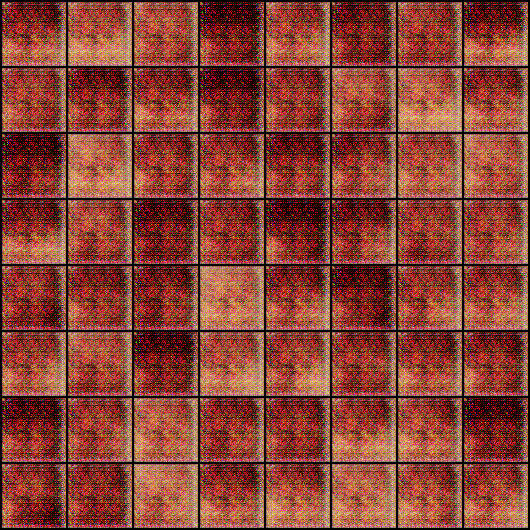

In [31]:
Image('/home/barc/Desktop/subir/Face-DCGAN/generated/generated-images-0001.png')

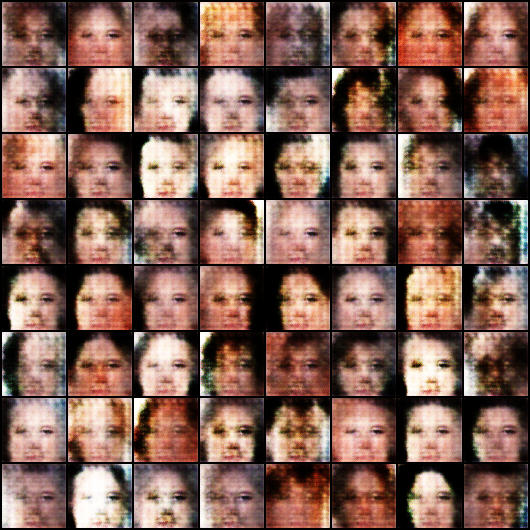

In [32]:
Image('/home/barc/Desktop/subir/Face-DCGAN/generated/generated-images-0005.png')

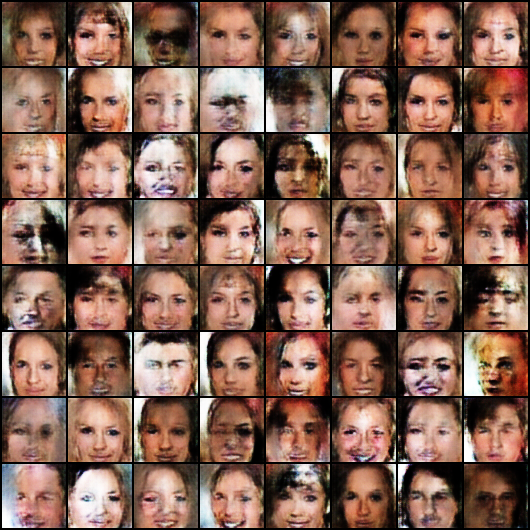

In [33]:
Image('/home/barc/Desktop/subir/Face-DCGAN/generated/generated-images-0010.png')

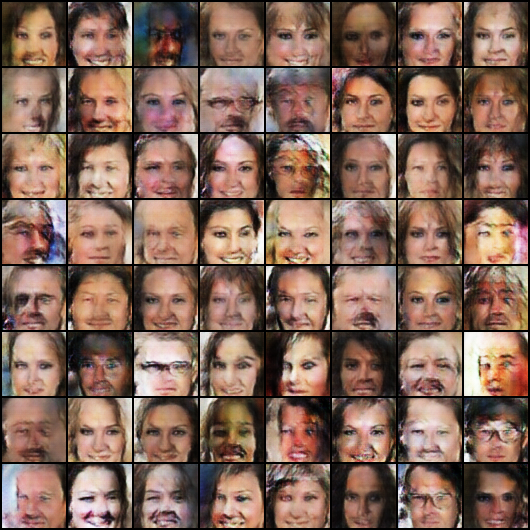

In [34]:
Image('/home/barc/Desktop/subir/Face-DCGAN/generated/generated-images-0020.png')

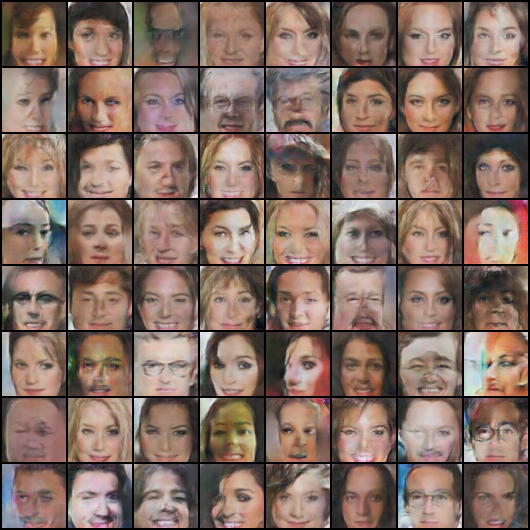

In [35]:
Image('/home/barc/Desktop/subir/Face-DCGAN/generated/generated-images-0050.png')

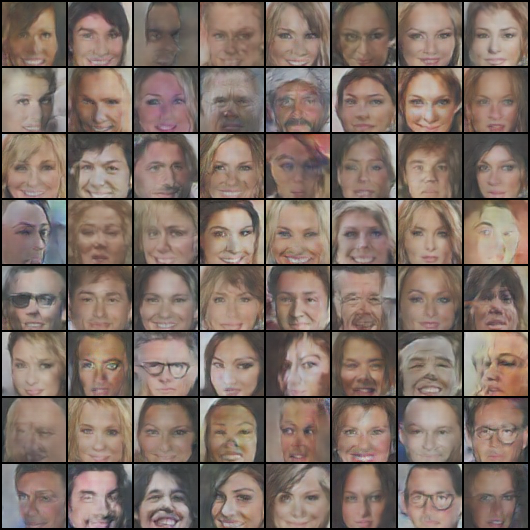

In [51]:
Image('/home/barc/Desktop/subir/Face-DCGAN/generated/generated-images-0100.png')

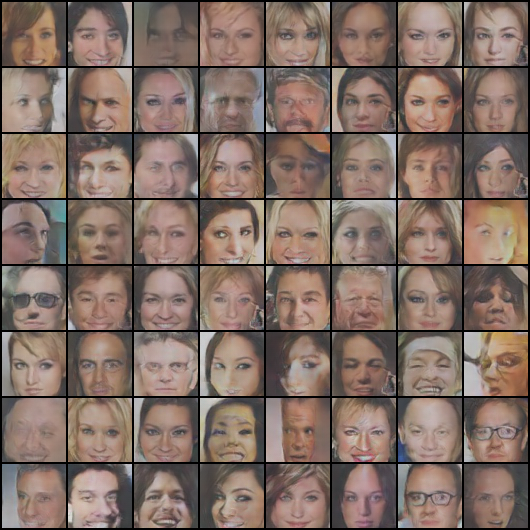

In [52]:
Image('/home/barc/Desktop/subir/Face-DCGAN/generated/generated-images-0200.png')

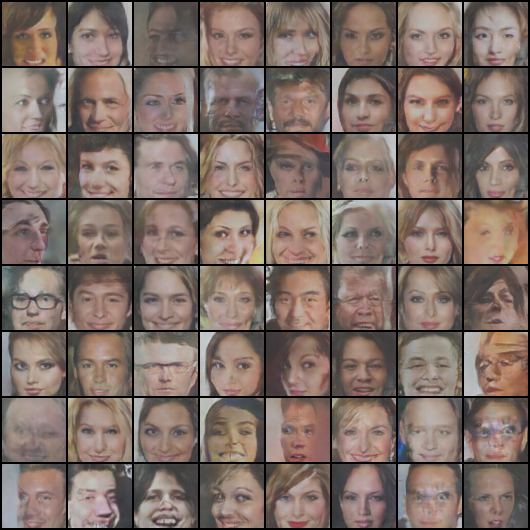

In [53]:
Image('/home/barc/Desktop/subir/Face-DCGAN/generated/generated-images-0300.png')

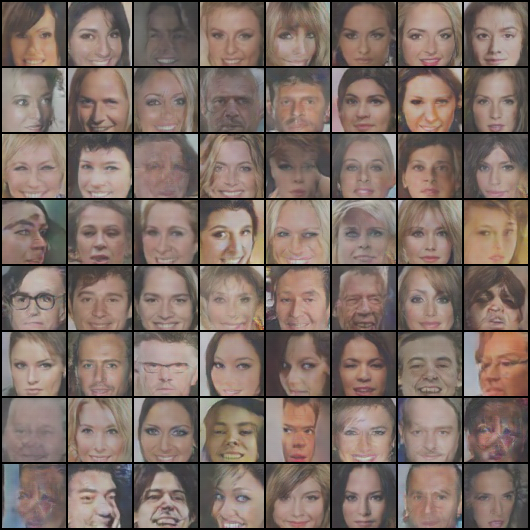

In [54]:
Image('/home/barc/Desktop/subir/Face-DCGAN/generated/generated-images-0500.png')

In [36]:
vid_fname = 'gans_training.avi'

files = [os.path.join(sample_dir, f) for f in os.listdir(sample_dir) if 'generated' in f]
files.sort()

out = cv2.VideoWriter(vid_fname,cv2.VideoWriter_fourcc(*'MP4V'), 1, (530,530))
[out.write(cv2.imread(fname)) for fname in files]
out.release()

OpenCV: FFMPEG: tag 0x5634504d/'MP4V' is not supported with codec id 12 and format 'avi / AVI (Audio Video Interleaved)'
OpenCV: FFMPEG: fallback to use tag 0x34504d46/'FMP4'


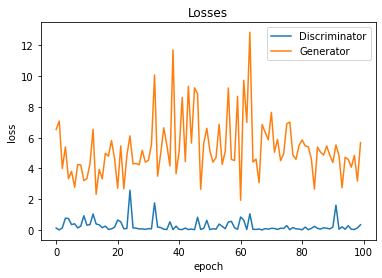

In [47]:
plt.plot(losses_d[0:100], '-')
plt.plot(losses_g[0:100], '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

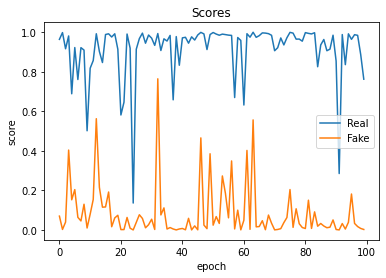

In [50]:
plt.plot(real_scores[0:100], '-')
plt.plot(fake_scores[0:100], '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real', 'Fake'])
plt.title('Scores');